## EVALUACION PARCIAL
### PROYECTO Mi-Bici
**TELLES AMEZCUA VICTOR MANUEL | 737066**

### **Importacion de librerias**
Importar librerias necesarias para el procesamiento, analisis y visualizacion de datos en el proyecto.

`pandas` = Para manipulacion y analisis de datos

`numpy` = Para calculos numericos y estructura de datos eficientes

`matplotlib` = Para la generacion de graficos estaticos

`Seaborn` = Para visualizacion de datos mas estilizada.

`streamlit` = Para crear interfaces interactivas con python.

`os` = Para gestion de archivos y directorios

`chardet` = Para caracteres especiales

In [1]:
#----- Importación de Librerías -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import random
from skimage import io
import os
import chardet

### **Variables globales**

In [2]:
LOGO_PATH = r'./media/images/MiBici_Logo.png'
LOGO_PATH_AGE = r'./media/images/Edad.png'
IMAGE_PATH_STATION = r'./media/images/Estacion.png'
GRAPH_PATH = r'./media/images/grafico.png'
#----- Configuracion datos -------------------------
DATA_FOLDER = r'data/MiBici-Data/Test'
DATA_NOMENCLATURA_FOLDER = r'data/Nomenclatura-Mibici-Data'
#----- Configuracion Cache -------------------------
CACHE_FOLDER = r'data/cache'
CACHE_FILE = os.path.join(CACHE_FOLDER, 'datos_procesados.parquet')

### **Deteccion de codificacion de archivos**
Antes de cargar los datos es importante procesar los archivos CSV, para poder conocer su codificacion para evitar errores de lectura. Esta funcion utiliza `chardet` para detectar la codificacion de un archivo.

`chardet.detect` = Para analizar el contenido del archivo y predecir su codificacion

`open(file, 'rb')` = Para leer el archivo en modo binario y evitar errores de codificacion

`raw_data.read()` = para cargar los datos del archivo en memoria

In [3]:
#----- Funciones para decodificacion -----------------------------
def dectect_encoding(file):
    '''Funcionalidad para dectectar la codificacion de un archivo'''
    with open(file, 'rb') as f:
        raw_data = f.read()
    result = chardet.detect(raw_data)
    return result['encoding']


### **Carga y procesamiento de Datos**
Se creo una funcion para cargar los datos de **MiBici** del formato .CSV, estandarizar nombres de columnas.

`pandas.read_csv` = para leer archivos CSV y convertirlos en dataFrame

`os.walk` = para recorrer directorios y listar archivos

`pandas.concat` = para combinar multiples DataFrames en uno solo

In [4]:
#----- Funciones para leer y procesamiento de datos --------------
def cargar_datos(data_folder):
    '''Funcionalidad para leer y procesar datos de un archivo CSV'''
    # Formato de las columnas correctas
    columnas_correctas = [
        "Trip_Id", "User_Id", "Gender", "Year_of_Birth",
        "Trip_Start", "Trip_End", "Origin_Id", "Destination_Id"
    ]

    #Diccionario para renombrar columnas
    renombrar_columnas = {
        "Viaje_Id": "Trip_Id",
        "Usuario_Id": "User_Id",
        "Genero": "Gender",
        "Año_de_nacimiento": "Year_of_Birth",
        "A}äe_nacimiento": "Year_of_Birth",
        "AÃ±o_de_nacimiento": "Year_of_Birth",
        "Aï¿½o_de_nacimiento": "Year_of_Birth",
        "Inicio_del_viaje": "Trip_Start",
        "Fin_del_viaje": "Trip_End",
        "Origen_Id": "Origin_Id",
        "Destino_Id": "Destination_Id"
    }

    #Lista, almacenar todos los dataframe
    dataframes = []

    #Iterar todos los archivos y subcarpetas
    for root, _, files in os.walk(data_folder):
        for file in files:
            # leer archivo CSV
            if file.endswith(".csv"):
                ruta_completa = os.path.join(root, file)
                ruta_completa = ruta_completa.replace("\\", "/")
                #print(f"📂 Intentando leer: {ruta_completa}")

                try:
                    #Dectectar la codificacion del archivo
                    encoding = dectect_encoding(ruta_completa)
                    #print(f"🔍 Codificación detectada: {encoding}")

                    #leer archivo
                    df = pd.read_csv(ruta_completa, encoding=encoding)

                    if df is not None and not df.empty:
                        #print(f"✅ Archivo cargado correctamente: {ruta_completa}")

                        # Renombrar columnas
                        df = df.rename(columns=renombrar_columnas, inplace=False)
                        # Verificar si las columnas están en el orden correcto
                        df = df[[col for col in columnas_correctas if col in df.columns]]
                        #print(f"📊 Columnas renombradas y ordenadas correctamente {df.columns}")

                        #Extraer el año, mes  del archivo
                        nombre_archivo = os.path.basename(ruta_completa)
                        partes = nombre_archivo.split('_')
                        if len(partes) >= 4:
                            anio = int(partes[2])
                            mes = int(partes[3].split('.')[0])
                            df['Year'] = anio
                            df['Month'] = mes

                        #Agregar datos al dataframe
                        dataframes.append(df)
                        st.success(f'✅ Datos cargados: {ruta_completa} - Columnas: {df.columns.tolist()}')
                    else:
                        #print(f"⚠️ Archivo vacío o no se pudo leer: {ruta_completa}")
                        st.error(f'❌ No se pudo leer el archivo: {ruta_completa} esta vacio o no se pudo leer')

                except Exception as e:
                    #print(f"❌ Error leyendo {ruta_completa}: {e}")  # Debugging
                    st.error(f'❌ Error al leer el archivo {ruta_completa}: {e}')

    # Concatenar todos los datos del dataframe en 1
    if dataframes:
        all_data = pd.concat(dataframes, ignore_index=True)
        st.success('Datos cargados y unificados correctamente')
        return all_data
    else:
        st.error('No se pudieron concatenar los datos')
        return  None

### **Carga y procesamiento de Datos | Nomenclatura**
Se creo una funcion para cargar los datos de **MiBici** pero relacionado con la **nomenclatura** del formato .CSV.

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~ Nomenclatura ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def cargar_nomenclatura(data_nomenclatura_folder):
    '''Funcionalidad para cargar los datos de Nomenclatura de MiBici'''
    nomenclatura_dataframes = []

    # Debug: Verificar si la carpeta existe
    #print(f'📂 Verificando si la carpeta de nomenclatura existe: {os.path.exists(data_nomenclatura_folder)}')

    #Cargar y procesar el archivo de nomenclatura
    for root, _, files in os.walk(data_nomenclatura_folder):
        #print(f'📁 Explorando: {root} - Archivos encontrados: {files}')
        for file in files:
            if file.endswith(".csv"):
                #Lectura de archivo
                ruta_completa = os.path.join(root, file)
                ruta_completa = ruta_completa.replace('\\','/')
                #print(f'📂 Intentando leer: {ruta_completa}')

                try:
                    #Dectectar codificador
                    encoding = dectect_encoding(ruta_completa)
                    #print(f'🔍 Codificacion dectectada: {encoding}')

                    #leer CSV
                    df = pd.read_csv(ruta_completa, encoding=encoding)
                    #print(f'✅ Archivo leido correctamente: {ruta_completa}')

                    if df is not None and not df.empty:
                        #añadir datos al dataframe
                        nomenclatura_dataframes.append(df)

                    else:
                        st.error(f'❌ Archivo vacio o no se pudo leer: {ruta_completa}')
                except Exception as e:
                    st.error(f'❌ Error al leer el archivo {ruta_completa}: {e}')
                    #print(f'🛑 Detalles del error: {str(e)}')

    if nomenclatura_dataframes:
        nomenclatura_df = pd.concat(nomenclatura_dataframes, ignore_index=True)
        #print(f' Dataframe final de nomenclatura: {nomenclatura_df.shape}')

        return nomenclatura_df
    else:
        st.error('No se pudieron cargar los datos de Nomenclatura')
        return None


### **Manejamiento de valores null/vacios**
Se elimina valores nulos en columnas criticas y se aplica `ffill` para completar datos faltantes. en este caso lo aplicamos para ambos archivos. datos de mibici y la nomenclatura.

---

`dropna` = Para eliminar valores nulos

`fillna` = Para rellenar valores nulos con datos previos.

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~ Manejamiento de valores vacios/null ~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def manejar_valores_nulos_mibici(df):
    '''Funcionalidad para manejar valores nulos en el dataframe de "MiBici" '''
    if df is not None and not df.empty:
        #no pueden contener valores nulos
        columnas_criticas = ["Trip_Id", "User_Id", "Origin_Id", "Destination_Id"]

        #Eliminar filas con valor nulos
        df = df.dropna(subset=columnas_criticas)

        #Rellenar valores nulos
        df = df.ffill()

        st.success('Valores Nulos en datos de MiBici Manejados correctamente')
    return df

def manejar_valors_nulos_nomenclatura(df):
    '''Funcionalidad para manejar valores nulos en el dataframe de "Nomenclatura"'''
    if df is not None and not df.empty:
        #no pueden contener valores nulos
        columnas_criticas = ["id", "name", "latitude", "longitude"]

        # Eliminar filas con valor nulos
        df = df.dropna(subset=columnas_criticas)

        #Rellenar valores nulos
        df = df.ffill()

        st.success('Valores Nulos en datos de Nomenclatura Manejados correctamente')
    return df


### **Manejamiento de incosistencias.**
Las fechas de inicio y fin de viaje pueden tener incosistencias o valores no validos.
Por lo que:
`datetime` = Convierte las fechas a formato **datetime**
Elimina valores nulos e invalidos
Filtra viajes con horas irreales (12:00 y 15:00)
Se le da formato a las fechas `(YYYY - MM - DD HH:MM:SS)`

---

`pd.to_datetime` = Convierte cadenas a formato de texto y hora

`dropna(subnet = [...])`Elimina el registro con fecha nulas.

`strftime('%H:%M:%S)` = Extrae la hora de una fecha

`dt.strftime(%Y-%m-%d %H:%M:%S)` = formatea las fechas en un formato estandar.

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~ Manejamiento incosistencias ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def manejar_fecha(df):
    '''Funcionalidad para manejar inconsistencia de fecha y hora inicio/fin '''
    if df is not None and not df.empty:
        # Convertir las columnas de fecha a datetime
        df['Trip_Start'] = pd.to_datetime(df['Trip_Start'], format='mixed', errors='coerce')
        df['Trip_End'] = pd.to_datetime(df['Trip_End'], format='mixed', errors='coerce')

        # Eliminar filas con fechas inválidas
        df = df.dropna(subset=['Trip_Start', 'Trip_End'])

        # Eliminar datos de prueba (horas perfectas (12 y 15))
        df = df[~(
            (df['Trip_Start'].dt.strftime('%H:%M:%S') == '12:00:00') & 
            (df['Trip_End'].dt.strftime('%H:%M:%S') == '15:00:00')
        )]

        # Asegurar el formato AAAA-MM-DD HH:MM:SS
        df['Trip_Start'] = df['Trip_Start'].dt.strftime('%Y-%m-%d %H:%M:%S')
        df['Trip_End'] = df['Trip_End'].dt.strftime('%Y-%m-%d %H:%M:%S')

        #print('Inconsistencias en fechas corregidas correctamente')
    return df

### **Calcular costos por viaje**
Se creo esta funcionalidad debido a que en un futuro se requiere esta funcion para mandar a llamar el calculo y poder hacer un grafico base a eso

---

Reglas:
- Costo individual al dia = `108 MXN`

- Costo extra de `29 MXN` despues de los primeros 30 minutos

- costo adicional de `40 MXN` por cada infraccion de 30 minutos extra minutos

- Costo extra de `29 MXN` despues de los primeros 30 minutos

In [8]:
def calcular_costo(travel_time):
    '''Funcionalidad para calcular el costo de MiBici'''
    base_cost = 108
    extra_cost = 0

    total_minutes = travel_time.total_seconds() / 60
    if total_minutes > 30:
        extra_minutes = total_minutes - 30
        extra_cost += 29
        extra_minutes -= 30

        if extra_minutes > 0:
            extra_minutes += (extra_minutes // 30) * 40
            if extra_minutes % 30 > 0:
                extra_cost += 40

    return base_cost + extra_cost


### **Gestion de cache**
Se implemento una funcionalidad de cache, debido a que cada que ejecutabas el streamlit, tenias que recargar los datos (En mi programa) sin embargo se implemento una funcionalidad de cache para tener todos los datos en un solo archivo y de ahi mismo a hacer la lectura para todo sin necesidad de volver a recargar todo.

---

`save_cache` = Guarda un dataframe en cache

`load_cache` =carga un Dataframe desde la cache cache

---

`@st.cache_data` = Decorador de streamlit para almacenar datos en cache y evitar recoputaciones innecesarias

`df.to_parquet()` = Guarda un DataFrame en formato `.parquet` para almacenamiento eficientes

`pd.read_parquet()` = Carga un DataFrame desde un archivo `.parquet`

`os.path.exists()` = Verifica si el archivo de cache existe antes de intentar leerlo.

In [9]:
#----- Cache  -----------------------------------
@st.cache_data
def save_cache(df, cache_file):
    '''Funcionalidad para guardar el Dataframe en un archivo cache'''
    if df is not None and not df.empty:
        #print(f"💾 Guardando datos en cache: {df.shape}")
        df.to_parquet(cache_file)

@st.cache_data
def load_cache(cache_file):
    '''Funcionalidad para guardar el Dataframe en un archivo cache'''
    if os.path.exists(cache_file):
        try:
            df = pd.read_parquet(cache_file)
            #print(f"✅ Archivo cache cargado correctamente: {df.shape}")
            return df
        except Exception as e:
            #print(f"❌ Error cargando archivo cache: {e}")
            return None
        #return pd.read_parquet(cache_file)
    else:
        #print("⚠️ Archivo cache no encontrado")
        return None


2025-02-25 16:46:38.738 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-02-25 16:46:38.741 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


### **Agrupacion de Estaciones con Nomenclatura**
La funcion `estaciones()` permite asociar los identificadores de las estaciones (`Origin_Id` y `Destination_Id`) con sus nombres correspondientes en la nomenclatura. Esto facilita la interpretacion de los datos, ya que en lugar de los numeros de estacion, se presentan los nombres reales.

---

`merge(left_on, right_on, how='left')` = Realiza una union entre 2 DataFrames para agregar informacion relevante

`rename(columns={})` = Cambia los nombres de columnas para mejor claridad.

`drop(columns=[])` = Elimina columnas innecesarias tras la fusion

In [10]:
#----- Funcionalidad para agrupar las estaciones ----------------------
def estaciones(df_mibici, df_nomenclatura):
    '''Funcionalidad para Agrupar (Origin_Id y Destination_Id) con las estaciones (nomenclatura (id))'''
    # Seleccionar columnas relevantes de nomenclatura
    df_nomenclatura = df_nomenclatura[['id', 'name']].rename(columns={'id': 'Station_Id', 'name': 'Station_Name'})

    # Unir datos de MiBici con nomenclatura para obtener el nombre de la estación de origen
    df_mibici = df_mibici.merge(df_nomenclatura, left_on='Origin_Id', right_on='Station_Id', how='left') \
                        .rename(columns={'Station_Name': 'Origin_Station'}) \
                        .drop(columns=['Station_Id'])

    # Unir datos de MiBici con nomenclatura para obtener el nombre de la estación de destino
    df_mibici = df_mibici.merge(df_nomenclatura, left_on='Destination_Id', right_on='Station_Id', how='left') \
                        .rename(columns={'Station_Name': 'Destination_Station'}) \
                        .drop(columns=['Station_Id'])

    return df_mibici[['Trip_Id', 'Origin_Id', 'Origin_Station', 'Destination_Id', 'Destination_Station']]


### **Conteo de Viajes por estacion**
Esta funcion cuenta con la cantidad de viajes que **salen de** o **llegan a** cada estacion y los asocia con su respectivo nombre de estacio. Esto permite identificar las estaciones mas utilizadas.

---

`value_counts()` = Cuenta la frecuencia de cada estacion en los viajes.

`reset_index()` = Convierte los conteos de un Dataframe estructurado.

`merge(left_on, right_on, how='left')` = Une los conteos con los nombres de las estaciones

`drop_duplicates()` = Elimina registros duplicados en la union de datos


In [11]:
#----- Generar un conteo x Estacion ------------------------------
def conteo_estacion(df_mibici, df_nomenclatura, tipo):
    '''Funcionalidad para generar un conteo de viajes por estaciones'''
    # Cargar los datos
    df_agrupado = estaciones(df_mibici, df_nomenclatura)

    # Si el df esta vacio, regresar None
    if df_agrupado is None or df_agrupado.empty:
        return None

    if tipo == 'Salen':
        # Contar la cantidad de viajes por estación de salida
        conteo = df_agrupado['Origin_Id'].value_counts().reset_index()
        conteo.columns = ['Origin_Id', 'OutCount_Station']

        # Juntar el Id y contador con los nombres de las estaciones de origen
        conteo = conteo.merge(df_agrupado[['Origin_Id', 'Origin_Station']].drop_duplicates(), on='Origin_Id', how='left')
        return conteo[['Origin_Id', 'Origin_Station', 'OutCount_Station']]

    elif tipo == 'Llegan':
        # Contar la cantidad de viajes por estación de llegada
        conteo = df_agrupado['Destination_Id'].value_counts().reset_index()
        conteo.columns = ['Destination_Id', 'InCount_Station']

        # Juntar el Id y contador con los nombres de las estaciones de destino
        conteo = conteo.merge(df_agrupado[['Destination_Id', 'Destination_Station']].drop_duplicates(), on='Destination_Id', how='left')
        return conteo[['Destination_Id', 'Destination_Station', 'InCount_Station']]

    return None


### **Calculo de la edad del usuario**
Esta funcion calcula la edad del usuario basandose en su año de nacimiento `(Year_of_Birth)`. Se aplica validaciones para evitar errores y datos incoherentes.

---

`pd.to_numeric()` = Convertir los valores a formato numerico.

`isnull().all()` = Verifica si todos los valores de una columna son nulos.

`loc[]` = Filtra valores incorrectos en la columna `Age`

`pd.NA` = Maneja valores nulos correctamente en Pandas.


In [12]:
#----- Funcionalidad para crear columna Edad ----------------------
def edad(df):
    '''Funcionalidad para añadir columna de la edad del usuario'''
    if 'Year_of_Birth' not in df.columns:
        st.error('❌ No se pudo calcular la edad porque la columna Year_of_Birth no se encuentra')
        return df

    df['Age'] = pd.to_numeric(df['Year_of_Birth'], errors='coerce') #Convertir numerico

    #Manejamiento de error de valores null
    if df['Year_of_Birth'].isnull().all():
        st.error('❌ No se puede calcular la edad porque todos los valores de "Year_of_Birth" son nulos.')
        return df

    # Funcion Calcular la edad
    df['Age'] = 2025 - df['Age']
    df.loc[(df['Age'] < 0) | (df['Age']> 150), 'Age'] = pd.NA # Filtrar valores erroneos (Limite excedido)
    return df


### **Calculo del tiempo de recorrido**
Esta funcion calcula el tiempo transcurrido entre la hora inicio `(Trip_Start)` y la hora de finalizacion `(Trip_End)` de un viaje y lo almacena en una nueva columna `Travel_Time`. Se asegura de manejar valores nulos y diferencias de tiempo mayores a 24 horas.

---

`pd.to_datetime()` = Convierte las columnas a formato de fecha y hora.

`apply(lambda x: str(x).split()[-1])` = Extrae el tiempo en HH:MM:SS

`if 'days' not in str(x)` = Maneja diferencias de mas de 24 horas correctamente

`st.error()` = Muestra errores en Streamlit si los datos son invalidos.


In [13]:
#----- Funcionalidad para crear columna de Tiempo recorrido --------
def tiempo_recorrido(df):
    '''Funcionalidad para añadir columna de "Travel_Time" calcular el tiempo de (Trip_Start y Trip_End)'''
    if df is None or df.empty:
        st.error('El DataFrame esta vacio o no es valido')
        return None

    try:
        #Convertir formato tiempo
        df['Trip_Start'] = pd.to_datetime(df['Trip_Start'])
        df['Trip_End'] = pd.to_datetime(df['Trip_End'])

        #Calculo para distancia
        df['Travel_Time'] = (df['Trip_End'] - df['Trip_Start'])

        #Formatear la diferencia en formato HH:MM:SS
        df['Travel_Time'] = df['Travel_Time'].apply(
            lambda x:str(x).split()[-1]
            if 'days' not in str(x) else(x) # Manejar diferencias > 24 H
        )

        #st.success('Columna "Travel_Time" agregada correctamente')
        return df

    except Exception as e:
        st.error('❌ No se pudo calcular el tiempo de recorrido porque la columna "')
        return None


### **Calculo de Manhattan (distancia)**
Esta funcion de manhattan calcula la distancia base a la longitud y latitud de la tabla de nomenclatura para poder sacar una distancia aproximada

In [14]:
#----- Funcionalidad para calcular la distancia de manhattan ------
def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calcula la distancia de Manhattan en kilómetros."""
    lat_diff = abs(lat2 - lat1) * 111  # Aprox 111 km por grado de latitud
    lon_diff = abs(lon2 - lon1) * 111  # similar para la longitud
    return lat_diff + lon_diff



### **Distancia aproximado con tiempo**
Esta funcion calcula la distancia recorrida en un vviaje y al duracion del mismo. Utiliza la distancia Manhattan utilizando la longitud y latitude.

---
`manhattan_distance` = Metodo para calcular la distancia basado en la geometria

`duration_min` = hace el calculo entre `Trip_Start` y `Trip_End` y genera la columna de duracion del viaje en minutos

In [15]:
#----- Funcionalidad para crear un dataframe con distancia recorrida y tiempo
def distancia_tiempo(datos_filtrados, nomenclatura):
    """
    Funcionalidad para calcular la distancia recorrida.
    - Si el viaje está en diferentes estaciones, usa la distancia Manhattan.
    - Si inicia y termina en la misma estación, estima la distancia usando el tiempo de viaje.
    - Filtra viajes con duración menor a 1 minuto.
    """
    try:
        # Validar datos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos disponibles para calcular la distancia.')
            return None

        if nomenclatura is None or nomenclatura.empty:
            st.error('❌ No hay datos de nomenclatura disponibles.')
            return None

        # Unir nomenclatura para obtener latitud y longitud
        datos = datos_filtrados.merge(
            nomenclatura[['id', 'name', 'latitude', 'longitude']],
            left_on='Origin_Id', right_on='id', how='left'
        ).rename(columns={'name': 'Origin_Station', 'latitude': 'Origin_Lat', 'longitude': 'Origin_Lon'}).drop(columns=['id'])

        datos = datos.merge(
            nomenclatura[['id', 'name', 'latitude', 'longitude']],
            left_on='Destination_Id', right_on='id', how='left'
        ).rename(columns={'name': 'Destination_Station', 'latitude': 'Destination_Lat', 'longitude': 'Destination_Lon'}).drop(columns=['id'])

        # Calcular distancia de Manhattan
        datos['Distance_KM'] = datos.apply(lambda row: manhattan_distance(
            row['Origin_Lat'], row['Origin_Lon'], row['Destination_Lat'], row['Destination_Lon']
        ) if row['Origin_Id'] != row['Destination_Id'] else np.nan, axis=1)

        # Calcular tiempo de viaje en minutos
        datos['Trip_Start'] = pd.to_datetime(datos['Trip_Start'])
        datos['Trip_End'] = pd.to_datetime(datos['Trip_End'])
        datos['Duration_Min'] = (datos['Trip_End'] - datos['Trip_Start']).dt.total_seconds() / 60

        # Aproximar distancia si es la misma estación (pensando que: 150m/min como velocidad promedio)
        datos.loc[datos['Origin_Id'] == datos['Destination_Id'], 'Distance_KM'] = datos['Duration_Min'] * 0.15

        # Eliminar viajes con duración menor a 1 minuto
        datos = datos[datos['Duration_Min'] >= 1]

        # Redondear duración a minutos enteros
        datos['Duration_Min'] = datos['Duration_Min'].astype(int)

        # Seleccionar las columnas finales
        resultado = datos[['Trip_Id', 'Origin_Station', 'Destination_Station', 'Distance_KM', 'Duration_Min']]

        return resultado

    except Exception as e:
        st.error(f'❌ No se pudo calcular la distancia. Error: {str(e)}')
        return None


## **Grafica Lineal:**
### **Cantidad de viajes (Mes / Año)**
Esta funcion genera una grafica linea que muestra la cantidad de viajes por mes o por año, dependiendo de la opcion seleccionada.

---

`groupby & size` = Agrupar y contar la cantidad de viajes.

`sns.lineplot` = Creacion de grafico lineal

`plt.figure, plt.xlabel, plt.ylabel, plt.grid` = Configuracion del grafico

`streamlit` = Para mostrar la interfaz y resultados


In [16]:
#===== Grafica Lineal ==== Cantidad de viajes * (Mes y año) ======
def graf_viaje(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    ''' Grafica Lineal para contar la cantidad de viajes por mes y año'''
    try:
        # Validar datos no vengan vacios
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la grafica')
            return

        # Opcion
        if opcion_filtrado == 'Año x Meses':
            # Agrupar por mes y contar la cantidad de viajes
            viajes_count = datos_filtrados.groupby('Month').size().reset_index(name='Cantidad_Viajes')
            # Configuracion Grafica
            titulo = f'Cantidad de viajes por Meses del (Año: {year_selected})'
            x_label = 'Mes'
            x_values = viajes_count['Month']
        else:
            # Agrupar por año y contar la cantidad de viajes
            viajes_count = datos_filtrados.groupby('Year').size().reset_index(name='Cantidad_Viajes')
            # Configuracion Grafica
            titulo = f'Cantidad de viajes por Años del (Mes: {month_selected})'
            x_label = 'Año'
            x_values = viajes_count['Year']

        # Mostrar Datos de conteo de viajes
        st.markdown('#### 📊 Conteo de Viajes:')
        st.dataframe(viajes_count)

        #creacion de la grafica
        plt.figure(figsize=(10,6))
        sns.lineplot(data=viajes_count, x=x_values, y='Cantidad_Viajes', marker='o')
        plt.title(titulo, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel('Cantidad de Viajes', fontsize=12)
        plt.grid(True)
        plt.tight_layout()

        #Mostrar grafico
        return st.pyplot(plt)
    except Exception as e:
        st.error('❌ No se pudo generar la gráfica de viajes')


## **Grafica Barras:**
### **Promedio de viaje (Dia * Semana)**
Grafica de barras que muestra el promedio de viajes de MiBici por dia de la semana, permitiendo filtrado por mes o año.

---

**Pandas** = para manipulación y transformación de datos ``(pd.to_datetime, value_counts, reindex)``

**Sns (Seaborn)** = para crear gráficos de barras `sns.barplot`

**Matplotlib** = para configuraciones de la gráfica `plt.figure, plt.xlabel, plt.ylabel, plt.xticks, plt.grid`

**Streamlit** = para mostrar la interfaz y resultados `st.error, st.markdown, st.dataframe, st.pyplot`


In [17]:
#===== Grafica Barras ==== Promedio de viaje (dia * semana) ======
def graf_uso_semanal(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    ''' Grafica para contar el uso de MiBici por semana'''
    try:
        #Validar datos no esten vacios
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la grafica')
            return
        #Convertir a datetime
        datos_filtrados['Trip_Start'] = pd.to_datetime(datos_filtrados['Trip_Start'])
        #Obtener el dia de la semana (0 = Lunes - 6 = Domingo)
        datos_filtrados['Day_Week'] = datos_filtrados['Trip_Start'].dt.dayofweek
        #Diccionario para mapear el # a dias
        dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miercoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sabado', 6: 'Domingo',}
        #Remplazar los valores numericos a nombre del dia
        datos_filtrados['Day_Week'] = datos_filtrados['Day_Week'].map(dias_semana)
        #Conteo de # viajes por cada dia de la semana
        count_viajes = datos_filtrados['Day_Week'].value_counts().reindex(dias_semana.values(), fill_value = 0)

        #Opcion filtrado [Año x Meses | Mes x Año]
        if opcion_filtrado == "Año x Meses":
            titulo = f'Uso de MiBici por Día de la Semana - Año {year_selected}'
            subtitulo = f'Meses seleccionados: {month_selected}'
        elif opcion_filtrado == "Mes x Años":
            titulo = f'Uso de MiBici por Día de la Semana - Mes {month_selected}'
            subtitulo = f'Años seleccionados: {year_selected}'
        else:
            titulo = 'Uso de MiBici por Día de la Semana'
            subtitulo = ''

        # Mostrar tabla de conteo
        st.markdown(f'#### 📊 {titulo}:')
        if subtitulo:
            st.markdown(f'{subtitulo}')
        st.dataframe(count_viajes.reset_index().rename(columns={'index': 'Day', 'Day_Week': 'Cantidad de Viajes'}))

        #Creacion y Configuracion Grafica
        plt.figure(figsize=(10,6))
        sns.barplot(x=count_viajes.index, y =count_viajes.values, hue=count_viajes.index, palette='coolwarm', legend=False)

        # conf.
        plt.title(f'{titulo}', fontsize=16)
        plt.xlabel('Dia de la semmana', fontsize=12)
        plt.ylabel('Cantidad de Viajes', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        #Mostrar grafico
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica de uso semanal {e}')


## **Grafica Barras:**
### **Uso de MiBici por dia**
Grafica de barras para visualizar el uso de MiBici por dia del mes permitiendo analizar la distribuccion de viajes en diferentes periodos de tiempo.


In [18]:
#===== Grafica Barras ==== Uso por Dias de MiBici ================
def graf_dias(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    '''Grafica para mostrar el uso de MiBici en los dias.'''
    try:
        #Validar que los datos no esten vacios
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la grafica.')
            return

        #Extraer el dia del mes
        datos_filtrados['Day'] = datos_filtrados['Trip_Start'].dt.day

        #Contar Viajes por dia y aplicar filtros
        if opcion_filtrado == 'Año x Meses':
            #Agrupar por Año-Mes-Dia
            count_days = datos_filtrados.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Count')
            # Convertir Month a string para visualización clara
            count_days['Month'] = count_days['Month'].astype(str)

        else:
            # Agrupar por Año-Mes-Día
            count_days = datos_filtrados.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Count')
            # Convertir Year a string para visualizarlo correctamente
            count_days['Year'] = count_days['Year'].astype(str)

        st.markdown('#### 📊 Conteo de Viajes por Día:')
        st.dataframe(count_days)

        # Creacion y conf la grafica
        plt.figure(figsize=(12,6))
        sns.set_style('whitegrid')

        if opcion_filtrado == 'Año x Meses':
            # Grafico varios meses del mismo año
            sns.lineplot(data=count_days, x = 'Day', y='Count', hue='Month', markers='o', palette='tab10')
            plt.title(f'Cantidad de Viajes por Día - Año: {year_selected}', fontsize=14)
            plt.xlabel('Día del Mes', fontsize=12)
            plt.ylabel('Cantidad de Viajes', fontsize=12)
            plt.legend(title="Meses")

        else:
            # Graficar múltiples años del mismo mes con distintos colores
            sns.lineplot(data=count_days, x='Day', y='Count', hue='Year', marker='o', palette='tab10')
            plt.title(f'Cantidad de Viajes por Día en el Mes: {month_selected}', fontsize=14)
            plt.xlabel('Día del Mes', fontsize=12)
            plt.ylabel('Cantidad de Viajes', fontsize=12)
            plt.legend(title="Años")

        # Mostrar la gráfica en Streamlit
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ No se pudo generar la grafica {str(e)}')


## **Grafica Histograma:**
### **Hombres vs Mujeres Uso MiBici**
Muestra un histograma que compara el uso de MiBici entre hombres y mujeres a lo largo de la semana. Se agrupan los datos por el dia de la semana y genero, permitiendo visualizar que dias tienen mayor uso por parte de cada genero.
La funcion incluye validaciones para evitar errores con datos vacios y muestra la informacion en una tabla antes de graficarla.


In [19]:
#===== Grafica Histograma === Hombres vs Mujeres = Uso de MiBici =
def graf_gender_versus(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    '''Grafica para mostrar la comparativa de H vs M al usar MiBici durante la semana'''
    try:
        #Validar que los datos no esten
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la grafica')
            return
        # Convertir a Trip_Start a datetime
        datos_filtrados['Trip_Start'] = pd.to_datetime(datos_filtrados['Trip_Start'])
        #Obtener el dia de la semana (0 = Lunes - 6 = Domingo)
        datos_filtrados['Day_Week'] = datos_filtrados['Trip_Start'].dt.dayofweek
        #Diccionario para mapear el # a dias
        dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miercoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sabado', 6: 'Domingo',}
        #Remplazar los valores numericos a nombre del dia
        datos_filtrados['Day_Week'] = datos_filtrados['Day_Week'].map(dias_semana)
        #Definir el orden correcto de los dias de la semana
        orden_dias = ['Lunes','Martes','Miercoles','Jueves', 'Viernes','Sabado','Domingo',]
        datos_filtrados['Day_Week'] = pd.Categorical(datos_filtrados['Day_Week'],categories = orden_dias, ordered=True)
        #Conteo de # viajes por genero durante la semana dia de la semana
        count_gender = datos_filtrados.groupby(['Day_Week', 'Gender'], observed=False).size().reset_index(name='Cantidad_Viajes')

        # Pivotear la tabla para que cada género sea una columna
        count_pivot = count_gender.pivot(index='Day_Week', columns='Gender', values='Cantidad_Viajes').fillna(0)

        #Opcion filtrado [Año x Meses | Mes x Año]
        if opcion_filtrado == "Año x Meses":
            titulo = f'Uso de MiBici por Día de la Semana - Año {year_selected}'
            subtitulo = f'Meses seleccionados: {month_selected}'
        elif opcion_filtrado == "Mes x Años":
            titulo = f'Uso de MiBici por Día de la Semana - Mes {month_selected}'
            subtitulo = f'Años seleccionados: {year_selected}'
        else:
            titulo = 'Uso de MiBici por Día de la Semana'
            subtitulo = ''

        # Mostrar la tabla
        st.markdown(f'#### 📊 {titulo}')
        if subtitulo:
            st.markdown(f'{subtitulo}')
        st.dataframe(count_pivot)

        # Crear la gráfica
        plt.figure(figsize=(10,6))
        colores = ['#ff69b4', '#1f77b4']
        count_pivot.plot(kind='bar', stacked=False, color=colores, alpha=0.8, width=0.8)

        # Configuración del gráfico
        plt.title(f'Comparativa H vs M de {titulo} ', fontsize=16)
        plt.xlabel('Día de la Semana', fontsize=12)
        plt.ylabel('Cantidad de Viajes', fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title='Genero', labels=['Mujeres', 'Hombres'])
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico en Streamlit
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ No se pudo generar la grafica')


## **Correlacion:**
### **Correlacion dia de las semanas**
Muestra un histograma que compara el uso de MiBici entre hombres y mujeres a lo largo de la semana. Se agrupan los datos por el dia de la semana y genero, permitiendo visualizar que dias tienen mayor uso por parte de cada genero.
La funcion incluye validaciones para evitar errores con datos vacios y muestra la informacion en una tabla antes de graficarla.


In [20]:
#===== Grafico Correlacion ==== Correlacion Dia de la semanas ====
def graf_dia_time(datos_filtrados):
    try:
        #Validar que los datos no esten
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la grafica')
            return

        # Llamar a la funcion para extraer el 'Travel_Time'
        datos_filtrados = tiempo_recorrido(datos_filtrados)

        # Validacion de que exista la columna "Travel_Time"
        if 'Travel_Time' not in datos_filtrados.columns:
            st.error('❌ La columna Travel_Time No existe, no se puede crear la funcion')
            return

        # Debbugin
        #st.write("Primeros 5 valores de Travel_Time:")
        #st.write(datos_filtrados[['Trip_Id', 'Trip_Start', 'Trip_End', 'Travel_Time']].head(15))

        #Convertir 'Travel_time' a timedelta
        if not pd.api.types.is_timedelta64_dtype(datos_filtrados['Travel_Time']):
            datos_filtrados['Travel_Time'] = pd.to_timedelta(datos_filtrados['Travel_Time'])

        #Diccionario para mapear el # a dias
        dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miercoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sabado', 6: 'Domingo',}
        datos_filtrados['Day_Week'] = datos_filtrados['Trip_Start'].dt.weekday.map(dias_semana)

#        #Calcular promedio de tiempo de viaje por dia de la semana
#        promedio_viajes = datos_filtrados.groupby('Day_Week')['Travel_Time'].mean().reset_index()
#        promedio_viajes['Travel_Time'] = promedio_viajes['Travel_Time'].dt.total_seconds() / 60  # Convertir a minutos

        #Ordenar dias de la semana
        orden_dias = ['Lunes','Martes','Miercoles','Jueves', 'Viernes','Sabado','Domingo',]
        datos_filtrados['Day_Week'] = pd.Categorical(datos_filtrados['Day_Week'],categories = orden_dias, ordered=True)
        datos_filtrados = datos_filtrados.sort_values('Day_Week')

        #Convertir Travel_Time a minutos
        datos_filtrados['Travel_Time_Minutos'] = datos_filtrados['Travel_Time'].dt.total_seconds() / 60

        #Calcular los percentiles
        y_min = datos_filtrados['Travel_Time_Minutos'].quantile(0.0) #percentil 0
        y_max = datos_filtrados['Travel_Time_Minutos'].quantile(0.99) #percentil 99

        # --- Gráfico de Dispersión con Línea de Tendencia ---
        fig, ax = plt.subplots(figsize=(10, 5))

        # Mapear los días de la semana a números para el eje X
        datos_filtrados['Day_Week_Num'] = datos_filtrados['Day_Week'].map({dia: i for i, dia in enumerate(orden_dias)})

        # Scatter plot
        sns.scatterplot(
            x='Day_Week_Num', 
            y='Travel_Time_Minutos', 
            data=datos_filtrados, 
            color='blue', 
            alpha=0.6, 
            ax=ax
        )

        # Línea de tendencia
        sns.regplot(
            x='Day_Week_Num', 
            y='Travel_Time_Minutos', 
            data=datos_filtrados, 
            scatter=False, 
            color='red', 
            ax=ax
        )

        #calcular el promedio de "Travel_Time_Minutos" por dia de la semana
        promedio_viajes = datos_filtrados.groupby('Day_Week')['Travel_Time_Minutos'].mean().reset_index()

        # Mostrar el promedio como una línea horizontal
        for dia, promedio in zip(promedio_viajes['Day_Week'], promedio_viajes['Travel_Time_Minutos']):
            ax.axhline(promedio, color='green', linestyle='--', alpha=0.5, label=f'Promedio {dia}: {promedio:.2f} min')

        # Configuración del gráfico
        ax.set_title("Correlación Día de la Semana - Tiempo de Viaje", fontsize=16)
        ax.set_xlabel("Día de la Semana", fontsize=12)
        ax.set_ylabel("Tiempo de Viaje (minutos)", fontsize=12)
        ax.set_xticks(range(len(orden_dias)))
        ax.set_xticklabels(orden_dias, rotation=45)
        ax.set_ylim(y_min, y_max)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico en Streamlit
        st.pyplot(fig)

        # --- Boxplot para ver distribución ---
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.boxplot(
            [datos_filtrados[datos_filtrados['Day_Week'] == dia]['Travel_Time_Minutos'] for dia in orden_dias],
            labels=orden_dias
        )
        ax.set_title("Distribución del Tiempo de Viaje por Día de la Semana", fontsize=16)
        ax.set_xlabel("Día de la Semana", fontsize=12)
        ax.set_ylabel("Tiempo de Viaje (minutos)", fontsize=12)
        ax.set_ylim(y_min, y_max)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico en Streamlit
        st.pyplot(fig)


    except Exception as e:
        st.error(f'❌ No se pudo generar la grafica {str(e)}')


In [21]:
def graf_dia_mes_time(datos_filtrados):
    try:
        # Validar que los datos no estén vacíos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la gráfica.')
            return

        # Llamar a la función para calcular la columna Travel_Time
        datos_filtrados = tiempo_recorrido(datos_filtrados)

        # Verificar si la columna Travel_Time se creó correctamente
        if 'Travel_Time' not in datos_filtrados.columns:
            st.error('❌ La columna "Travel_Time" no se pudo crear.')
            return

        # Convertir 'Travel_Time' a timedelta si no lo es
        if not pd.api.types.is_timedelta64_dtype(datos_filtrados['Travel_Time']):
            datos_filtrados['Travel_Time'] = pd.to_timedelta(datos_filtrados['Travel_Time'])

        # Extraer el día del mes de Trip_Start
        datos_filtrados['Day_Month'] = datos_filtrados['Trip_Start'].dt.day

        # Convertir Travel_Time a minutos
        datos_filtrados['Travel_Time_Minutos'] = datos_filtrados['Travel_Time'].dt.total_seconds() / 60

        # --- Opciones de Filtrado ---
        st.markdown('### Filtrado por Tiempo de Viaje')
        opcion_filtro = st.radio(
            'Selecciona una opción de filtrado:',
            ['Mostrar más de 1 minuto', 'Mostrar más de 15 minutos']
        )

        # Aplicar el filtro según la opción seleccionada
        if opcion_filtro == 'Mostrar más de 1 minuto':
            datos_filtrados = datos_filtrados[datos_filtrados['Travel_Time_Minutos'] >= 1]  # 1 minuto o más
        elif opcion_filtro == 'Mostrar más de 15 minutos':
            datos_filtrados = datos_filtrados[datos_filtrados['Travel_Time_Minutos'] >= 15]  # 15 minutos o más

        # --- Gráfico de Dispersión con Línea de Tendencia ---
        fig, ax = plt.subplots(figsize=(10, 5))

        # Debug: Verificar los valores de Travel_Time_Minutos
        st.write("Valores de Travel_Time_Minutos:")
        st.write(datos_filtrados['Travel_Time_Minutos'].describe())

        # Calcular los percentiles 5 y 95 para ajustar el eje y
        y_min = datos_filtrados['Travel_Time_Minutos'].quantile(0.05)  # Percentil 5
        y_max = datos_filtrados['Travel_Time_Minutos'].quantile(0.95)  # Percentil 95

        # Scatter plot
        sns.scatterplot(
            x='Day_Month', 
            y='Travel_Time_Minutos',  # Usar minutos directamente
            data=datos_filtrados, 
            color='blue', 
            alpha=0.6, 
            ax=ax
        )

        # Línea de tendencia
        sns.regplot(
            x='Day_Month', 
            y='Travel_Time_Minutos',  # Usar minutos directamente
            data=datos_filtrados, 
            scatter=False, 
            color='red', 
            ax=ax
        )

        # Configuración del gráfico
        ax.set_title(f"Correlación Día del Mes - Tiempo de Viaje ({opcion_filtro})", fontsize=16)
        ax.set_xlabel("Día del Mes", fontsize=12)
        ax.set_ylabel("Tiempo de Viaje (minutos)", fontsize=12)
        ax.set_xticks(range(1, 32))  # Días del mes (1-31)
        ax.set_ylim(y_min, y_max)  # Ajustar el eje y basado en percentiles
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico en Streamlit
        st.pyplot(fig)

        # --- Boxplot para ver distribución ---
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.boxplot(
            [datos_filtrados[datos_filtrados['Day_Month'] == dia]['Travel_Time_Minutos'] for dia in range(1, 32)],
            labels=range(1, 32)
        )
        ax.set_title(f"Distribución del Tiempo de Viaje por Día del Mes ({opcion_filtro})", fontsize=16)
        ax.set_xlabel("Día del Mes", fontsize=12)
        ax.set_ylabel("Tiempo de Viaje (minutos)", fontsize=12)
        ax.set_ylim(y_min, y_max)  # Ajustar el eje y basado en percentiles
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico en Streamlit
        st.pyplot(fig)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica. Error: {str(e)}')


## **Correlacion / Dispersion:**
### **Edad y Tiempo promedio**
Genera un grafico de dispersion que muestra la relacion entre la edad de los usuarios y el tiempo promedio de viaje en MiBici primero, valida que los datos no esten vacios y calcula la edad y la duracion de los viajes en minutos. luego lo agrupa con los datos de la edad, filtra los valores fuera de un rango logico (16-120 años).


In [22]:
#===== Grafica Correlacion ==== Edad - Tiempo promedio ==========
def graf_edad_time(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    '''Grafica para mostrar la edad con tiempo promedio'''
    try:
        # Validar que los datos no estén vacíos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la gráfica.')
            return

        #Calcular edad usuarios
        datos_filtrados = edad(datos_filtrados)

        #Calcular tiempo de viaje
        datos_filtrados = tiempo_recorrido(datos_filtrados)

        #Verificar que las columnas necesarias esten presentes
        if 'Age' not in datos_filtrados.columns or 'Travel_Time' not in datos_filtrados.columns:
            st.error('❌ No se pudieron calcular las columnas necesarias (Age o Travel_Time).')
            return

        #convertir Travel_Time a minutos
        datos_filtrados['Travel_Time'] = pd.to_timedelta(datos_filtrados['Travel_Time'])
        datos_filtrados['Travel_Time_Minutos'] = datos_filtrados['Travel_Time'].dt.total_seconds() / 60

        #Agrupar por edad y calcular el tiempo promedio de viaje
        tiempo_promedio_edad = datos_filtrados.groupby('Age')['Travel_Time_Minutos'].mean().reset_index()

        #Filtrar edades validas
        tiempo_promedio_edad = tiempo_promedio_edad[(tiempo_promedio_edad['Age'] >= 16) & (tiempo_promedio_edad['Age'] <= 120)]
        #Ajustar el Eje y
        y_max = tiempo_promedio_edad['Travel_Time_Minutos'].quantile(0.99) #percentil 99

        #Opcion filtrado [Año x Meses | Mes x Año]
        if opcion_filtrado == "Año x Meses":
            titulo = f'Correlacion Edad - Tiempo promedio de viaje. - Año {year_selected}'
            subtitulo = f'Meses seleccionados: {month_selected}'
        elif opcion_filtrado == "Mes x Años":
            titulo = f'Correlacion Edad - Tiempo promedio de viaje. - Mes {month_selected}'
            subtitulo = f'Años seleccionados: {year_selected}'
        else:
            titulo = 'Correlacion Edad - Tiempo promedio de viaje.'
            subtitulo = ''

        # Mostrar la tabla
        st.markdown(f'#### 📊 {titulo}')
        if subtitulo:
            st.markdown(f'{subtitulo}')
        st.dataframe(tiempo_promedio_edad)

        #Creacion de grafico
        fig, ax = plt.subplots(figsize = (12, 6))

        #ScatterPlot
        sns.scatterplot(
            x="Age",
            y="Travel_Time_Minutos",
            data=tiempo_promedio_edad,
            color='blue',
            alpha=0.6,
            ax=ax
        )

        #Linea de tendencia
        sns.regplot(
            x="Age",
            y="Travel_Time_Minutos",
            data=tiempo_promedio_edad,
            scatter=False,
            color='red',
            ax=ax
        )

        # conf
        ax.set_title(f'{titulo}', fontsize =16)
        ax.set_xlabel('Edad (>= 16) ', fontsize=12)
        ax.set_ylabel('Tiempo Promedio de viaje (Minutos)', fontsize=12)
        ax.set_ylim(0, y_max)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        #Mostrar grafico
        st.pyplot(fig)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica. Error: {str(e)}')


## **Pastel**
### **Rango de Edades**
Genera un grafico de Pastel que muestra el rango de edades de los usuarios que utilizan MiBici para transportarse.


In [23]:
#===== Grafica pastel ==== % Uso MiBici - Edad ===================
def graf_edad_pastel(datos_filtrados):
    '''Gráfica de pastel para mostrar el porcentaje de uso de MiBici por rango de edad'''
    try:
        # Validar que los datos no estén vacíos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la gráfica.')
            return

        # Calcular edad usuarios
        datos_filtrados = edad(datos_filtrados)

        # Verificar que la columna 'Age' está presente
        if 'Age' not in datos_filtrados.columns:
            st.error('❌ No se pudo calcular la edad de los usuarios.')
            return

        # Filtrar edades válidas (16 a 120 años)
        datos_filtrados = datos_filtrados[(datos_filtrados['Age'] >= 16) & (datos_filtrados['Age'] <= 120)]

        # Definir rangos de edad
        bins = [16, 25, 35, 45, 55, 65, 75, 120]
        labels = ['16-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
        datos_filtrados['Rango_Edad'] = pd.cut(datos_filtrados['Age'], bins=bins, labels=labels, right=False)

        # Contar cantidad de usuarios por rango de edad
        edad_counts = datos_filtrados['Rango_Edad'].value_counts().sort_index()

        # Crear gráfica de pastel
        fig, ax = plt.subplots(figsize=(8, 8))
        colores = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FFD700', '#FF69B4', '#B2B2B2']
        ax.pie(
            edad_counts,
            labels=edad_counts.index,
            autopct='%1.1f%%',
            colors=colores,
            startangle=140,
            wedgeprops={'edgecolor': 'black'}
        )
        ax.set_title('Distribución del Uso de MiBici por Rango de Edad')

        # Mostrar gráfica
        st.pyplot(fig)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica. Error: {str(e)}')


## **Grafica de barras:**
### **Uso por estaciones**
Genera una grafica de barras para mostrar el uso de estaciones en base a un tipo especifico de conteo (viajes de salida o llegada). Recibe datos filtrados y un Dataframe de nomenclatura y cuenta el numero de viajes por estacion. .


In [24]:
#===== Grafica Barras === Uso de estaciones  ====================
def graf_use_station(datos_filtrados, nomenclatura_df, tipo):
    '''Grafica para mostrar el uso de cada estacion'''
    try:
        # Validar que los datos no estén vacíos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la gráfica.')
            return

        #Obtener el conteo de viajes por estacion
        count = conteo_estacion(datos_filtrados, nomenclatura_df, tipo)

        # Validar que el conteo no se encuentre vacio
        if count is None or count.empty:
            st.error('❌ No se pudo generar el conteo de estaciones.')
            return

        #Extraer el identificador de c/Estacion
        if tipo == 'Salen':
            count['Station_Code'] = count['Origin_Station'].str.extract(r'\((.*?)\)')
            x_label = 'Estacion de Salida'
            y_label = 'Conteo de Viajes de Salida'
        elif tipo == 'Llegan':
            count['Station_Code'] = count['Destination_Station'].str.extract(r'\((.*?)\)')
            x_label = 'Estacion de Llegada'
            y_label = 'Conteo de Viajes de Llegada'
        else:
            st.error('❌ Tipo de conteo no valido. Usa "Salen" o "Llegan".')
            return

        #Ordenar por conteo de viajes
        count = count.sort_values(by=count.columns[2], ascending= False)

        # Creacion de grafico y configuracion

        # --- Grafico de barras ---
        plt.figure(figsize=(12,6))
        sns.barplot(
            x = 'Station_Code',
            y = count.columns[2],
            data = count,
            palette='coolwarm'
        )

        # conf grafico
        plt.title(f' Uso de Estaciones ({tipo})', fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        #Mostrar grafico
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica. Error: {str(e)}')


## **Grafica de barras:**
### **Total de dinero Gastado**
Grafica de barras que muestra el total de dinero gastado en funcion de los viajes, agrupados por dia de la semana. La funcion toma datos filtrados y filtra por año o mes segun la opcion que ha sido seleccionada. Calcula el costo de cada viaje en funcion del tiempo de viaje y lo agrupo por dia, sumando tel total de cada dia de la semana.

In [25]:
#===== Grafica barras ==== Total de dinero gastado (aproximado) =
def graf_money(datos_filtrados, opcion_filtrado, year_selected, month_selected):
    '''Grafica para mostrar el total de dinero gastado'''
    try:
        # Validar que los datos no estén vacíos
        if datos_filtrados is None or datos_filtrados.empty:
            st.error('❌ No hay datos filtrados para generar la gráfica.')
            return

        # Convertir Trip_Start a datetime si no está en formato datetime
        datos_filtrados['Trip_Start'] = pd.to_datetime(datos_filtrados['Trip_Start'], errors='coerce')

        # Extraer el día de la semana en español
        dias_semana = {
            'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miercoles',
            'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sabado', 'Sunday': 'Domingo'
        }
        datos_filtrados['Day'] = datos_filtrados['Trip_Start'].dt.day_name().map(dias_semana)

        # Convertir Travel_Time a minutos si es timedelta
        if pd.api.types.is_timedelta64_dtype(datos_filtrados['Travel_Time']):
            datos_filtrados['Travel_Time_Minutos'] = datos_filtrados['Travel_Time'].dt.total_seconds() / 60
        else:
            st.error('❌ Error: Travel_Time no está en formato timedelta.')
            return

        # Calcular costo
        datos_filtrados['Cost'] = datos_filtrados['Travel_Time'].apply(calcular_costo)

        # Agrupar por día de la semana y sumar el costo total
        costo_por_dia = datos_filtrados.groupby('Day', observed=True)['Cost'].sum().reset_index()

        # Ordenar días de la semana correctamente
        dias_ordenados = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
        costo_por_dia['Day'] = pd.Categorical(costo_por_dia['Day'], categories=dias_ordenados, ordered=True)
        costo_por_dia = costo_por_dia.sort_values('Day')

        #Opcion filtrado [Año x Meses | Mes x Año]
        if opcion_filtrado == "Año x Meses":
            titulo = f'Gasto total por dia de la semana - Año {year_selected}'
            subtitulo = f'Meses seleccionados: {month_selected}'
        elif opcion_filtrado == "Mes x Años":
            titulo = f'Gasto total por dia de la semana - Mes {month_selected}'
            subtitulo = f'Años seleccionados: {year_selected}'
        else:
            titulo = 'Gasto total por dia de la semana'
            subtitulo = ''

        # Mostrar la tabla
        st.markdown(f'#### 📊 {titulo}')
        if subtitulo:
            st.markdown(f'{subtitulo}')
        st.dataframe(costo_por_dia)

        # --- Gráfico de barras ---
        plt.figure(figsize=(10, 5))
        sns.barplot(
            x='Day',
            y='Cost',
            data=costo_por_dia,
            palette='summer'
        )

        # Configuración del gráfico
        plt.title(f'{titulo}', fontsize=14)
        plt.xlabel('Día de la semana', fontsize=12)
        plt.ylabel('Costo Total (MXN) Gastado', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Mostrar gráfico
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ No se pudo generar la gráfica. Error: {str(e)}')


### Grafica de pastel
## % Estaciones funcionales
Grafica que muestra un % en grafica de pastel de las estaciones funcionales o no funcionales

In [42]:
#===== Grafica Pastel ==== % estaciones funcionales o no func. ==
def graf_estacion_func(nomenclatura_df):
    """gráfico de pastel para visualizar la distribución de categorias de estaciones de MiBici."""
    try:
        # Verificar si el dataframe es válido
        if nomenclatura_df is None or nomenclatura_df.empty:
            st.warning('⚠ No hay datos disponibles para generar la gráfica.')
            return

        # Verificar que la columna "status" exista en el dataframe
        if "status" not in nomenclatura_df.columns:
            st.error('❌ La columna "status" no existe en el dataframe.')
            return

        # Contar cada tipo de estado
        conteo_status = nomenclatura_df["status"].value_counts()

        # Verificar si hay datos suficientes para graficar
        if conteo_status.empty:
            st.warning('⚠ No hay estados suficientes para generar la gráfica.')
            return

        # Configurar la figura
        plt.figure(figsize=(8, 6))

        # Crear el gráfico de pastel
        plt.pie(
            conteo_status,
            labels=conteo_status.index,
            autopct='%1.1f%%',
            colors=sns.color_palette("pastel"),
            startangle=170,
            wedgeprops={'edgecolor': 'black'}
        )

        plt.title('Distribución de Estaciones en Servicio')
        plt.axis('equal')  # Asegura que el gráfico sea un círculo

        # Mostrar en Streamlit
        st.pyplot(plt)

    except Exception as e:
        st.error(f'❌ Error al generar la gráfica: {str(e)}')

# Fase Main
De ahora en andelante es toda la funcionalidad main, para mandar a llamar las anteriores funciones y se generen las estadisticas o los graficos o los datos.


### Configuracion inicial y carga de datos

In [28]:
# Mostrar título
print("Datos de MiBici (2014-2024)")

# Opciones de caché
opcion_cache = "Cargar datos"  # Puedes cambiar esto a "Crear nuevos datos"

# Cargar o procesar datos
df = None
if opcion_cache == "Crear nuevos datos":
    print("Procesando datos desde la carpeta de origen...")
    df = cargar_datos(DATA_FOLDER)
    df = manejar_fecha(df)
    df = manejar_valores_nulos_mibici(df)
    if df is not None and not df.empty:
        save_cache(df, CACHE_FILE)
        print("✅ Datos procesados y guardados en caché")
    else:
        print("⚠ No se pudieron procesar los datos.")
else:
    print("Cargando datos desde el caché...")
    df = load_cache(CACHE_FILE)
    if df is not None and not df.empty:
        print(f"📊 Datos cargados correctamente desde caché: {df.shape}")
    else:
        print("⚠ No se encontraron datos en el caché. Seleccione 'Crear nuevos datos'.")

df.head(25)

Datos de MiBici (2014-2024)
Cargando datos desde el caché...
📊 Datos cargados correctamente desde caché: (30857971, 10)


,Trip_Id,User_Id,Gender,Year_of_Birth,Trip_Start,Trip_End,Origin_Id,Destination_Id,Year,Month
0,4601,10324,M,NaN,2014-12-01 00:33:47,2014-12-01 00:36:54,47,47,2014,12
1,4604,10324,M,NaN,2014-12-01 01:06:54,2014-12-01 01:08:45,5,5,2014,12
2,4628,3,F,1990.0,2014-12-01 09:47:20,2014-12-01 09:47:47,79,79,2014,12
3,4631,102,M,1982.0,2014-12-01 09:48:23,2014-12-01 09:48:37,79,79,2014,12
4,4632,3,F,1990.0,2014-12-01 09:48:46,2014-12-01 09:48:57,79,79,2014,12
5,4636,3,F,1990.0,2014-12-01 09:50:13,2014-12-01 09:50:18,79,79,2014,12
6,4637,102,M,1982.0,2014-12-01 09:49:05,2014-12-01 09:49:17,79,79,2014,12
7,4638,3,F,1990.0,2014-12-01 09:49:17,2014-12-01 09:49:29,79,79,2014,12
8,4639,102,M,1982.0,2014-12-01 09:49:28,2014-12-01 09:49:44,79,79,2014,12
9,4640,102,M,1982.0,2014-12-01 09:49:57,2014-12-01 09:50:09,79,79,2014,12


In [36]:
# Llamada de prueba para cargar datos desde el cache
df = load_cache(CACHE_FILE)
print(df.shape)
df.head()

(30857971, 10)


,Trip_Id,User_Id,Gender,Year_of_Birth,Trip_Start,Trip_End,Origin_Id,Destination_Id,Year,Month
0,4601,10324,M,NaN,2014-12-01 00:33:47,2014-12-01 00:36:54,47,47,2014,12
1,4604,10324,M,NaN,2014-12-01 01:06:54,2014-12-01 01:08:45,5,5,2014,12
2,4628,3,F,1990.0,2014-12-01 09:47:20,2014-12-01 09:47:47,79,79,2014,12
3,4631,102,M,1982.0,2014-12-01 09:48:23,2014-12-01 09:48:37,79,79,2014,12
4,4632,3,F,1990.0,2014-12-01 09:48:46,2014-12-01 09:48:57,79,79,2014,12


### Filtrado de datos 
Este apartado permite al usuario filtrar los datos por año y mes mostrando los datos filtrados de la interfaz


In [30]:
opcion_filtrado = 'Año x Meses'
# Filtrado de datos por año y mes
if df is not None and not df.empty:
    if opcion_filtrado == 'Año x Meses':
        year_avaliable = df['Year'].unique()
        year_selected = st.sidebar.selectbox('Selecciona el año:', year_avaliable)
        month_avaliable = df[df['Year'] == year_selected]['Month'].unique()
        month_selected = st.sidebar.multiselect('Selecciona los meses:', month_avaliable, default=month_avaliable)
        datos_filtrados = df[(df['Year'] == year_selected) & (df['Month'].isin(month_selected))]
    else:
        month_avaliable = df['Month'].unique()
        month_selected = st.sidebar.selectbox('Selecciona el mes', month_avaliable)
        year_avaliable = df[df['Month'] == month_selected]['Year'].unique()
        year_selected = st.sidebar.multiselect('Selecciona los años', year_avaliable, default=year_avaliable)
        datos_filtrados = df[(df['Month'] == month_selected) & (df['Year'].isin(year_selected))]

2025-02-25 17:09:19.756 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.760 Session state does not function when running a script without `streamlit run`
2025-02-25 17:09:19.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09:19.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:09

In [35]:
# Llamada de prueba para filtrar datos por año y mes
# Filtrado año 2023 y Mes 1,2,3
datos_filtrados = df[(df['Year'] == 2023) & (df['Month'].isin([1, 2, 3]))]
print(datos_filtrados.shape)
datos_filtrados.head()

(1123769, 10)


,Trip_Id,User_Id,Gender,Year_of_Birth,Trip_Start,Trip_End,Origin_Id,Destination_Id,Year,Month
21919079,26751198,1350606,M,1983.0,2023-01-01 00:00:41,2023-01-01 00:26:52,154,50,2023,1
21919080,26751199,15163,M,1986.0,2023-01-01 00:04:48,2023-01-01 00:07:46,64,79,2023,1
21919081,26751200,1534764,M,1987.0,2023-01-01 00:06:49,2023-01-01 00:17:36,35,12,2023,1
21919082,26751201,1240140,M,1996.0,2023-01-01 00:08:05,2023-01-01 00:09:00,35,35,2023,1
21919083,26751202,1732214,M,1969.0,2023-01-01 00:09:14,2023-01-01 00:14:57,54,171,2023,1


### Nomenclatura
Este apartado permite Cargar los datos de nomenclatura, los limpia y los muestra interfaz si el usuario lo solicita.

In [37]:
# Cargar y mostrar datos de nomenclatura
print("Cargando datos de nomenclatura...")
nomenclatura_df = cargar_nomenclatura(DATA_NOMENCLATURA_FOLDER)
if nomenclatura_df is not None and not nomenclatura_df.empty:
    nomenclatura_df = manejar_valors_nulos_nomenclatura(nomenclatura_df)
    save_cache(nomenclatura_df, os.path.join(CACHE_FOLDER, 'nomenclatura_cache.parquet'))
    print('Nomenclatura limpiada, cargada y guardada en cache')

# Mostrar las primeras filas de la nomenclatura
nomenclatura_df.head()

2025-02-25 17:13:43.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Cargando datos de nomenclatura...


2025-02-25 17:13:43.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:13:43.707 No runtime found, using MemoryCacheStorageManager
2025-02-25 17:13:43.720 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:13:43.721 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:13:43.723 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:13:43.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:13:43.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Nomenclatura limpiada, cargada y guardada en cache


,id,name,obcn,location,latitude,longitude,status
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691847,-103.362549,IN_SERVICE
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681158,-103.339363,IN_SERVICE


### Estaciones
- Visualizacion de estaciones y conteo de viajes

Este apartado muestra las estaciones y realiza un conteo de viajes por estacion, dependiendo de si los viajes son de salida o llegada.


In [38]:
# Mostrar datos de estaciones y conteo de viajes
if datos_filtrados is not None and nomenclatura_df is not None:
    estaciones_df = estaciones(datos_filtrados, nomenclatura_df)
    if estaciones_df is not None and not estaciones_df.empty:
        print("Datos de estaciones:")
        display(estaciones_df.head())
    else:
        print('No se encontraron datos de estaciones')

# Conteo de viajes por estación
tipo_conteo = "Salen"  # Ejemplo: conteo de viajes de salida
conteo_df = conteo_estacion(datos_filtrados, nomenclatura_df, tipo_conteo)
if conteo_df is not None and not conteo_df.empty:
    print(f"Conteo de viajes de {tipo_conteo}:")
    display(conteo_df.head())
else:
    print('No hay datos disponibles para el conteo de estaciones')

Datos de estaciones:


,Trip_Id,Origin_Id,Origin_Station,Destination_Id,Destination_Station
0,26751198,154,(GDL-087) Av. Américas / Av. López Mateos,50,(GDL-048) C. Constancio Hernández/ Av. Juaréz
1,26751199,64,(GDL-062) C. Libertad / C. Moscú,79,(GDL-077) C. Argentina / C. Pedro Moreno
2,26751200,35,(GDL-033) Av. Hidalgo / C. Pedro Loza,12,(GDL-010) C. Cruz verde / C. Joaquin Angulo
3,26751201,35,(GDL-033) Av. Hidalgo / C. Pedro Loza,35,(GDL-033) Av. Hidalgo / C. Pedro Loza
4,26751202,54,(GDL-052) Av. Juárez / Av. 16 de Septiembre,171,(GDL-104) C. Pedro Loza / Av. Manuel Acuña


Conteo de viajes de Salen:


,Origin_Id,Origin_Station,OutCount_Station
0,51,(GDL-049) Lopez Cotilla/ Marcos Castellanos,25878
1,11,(GDL-009) Calz. Federalismo/ C. J. Angulo,18232
2,271,(GDL-198) Av. Alcalde / C. Hospital,17465
3,52,(GDL-050) C. Pedro Moreno / Calz. Federalismo,16174
4,35,(GDL-033) Av. Hidalgo / C. Pedro Loza,15369


### Distancia recorrida
Calcular distancia recorrida
Este apartado calcula la distancia recorrida por los usuarios y muestra los resultados.


In [39]:
# Calcular y mostrar distancia recorrida
df_distancia = distancia_tiempo(datos_filtrados, nomenclatura_df)
if df_distancia is not None and not df_distancia.empty:
    print("Distancia Recorrida (Aproximación):")
    display(df_distancia.head())
else:
    print('No hay datos disponibles para mostrar.')

Distancia Recorrida (Aproximación):


,Trip_Id,Origin_Station,Destination_Station,Distance_KM,Duration_Min
0,26751198,(GDL-087) Av. Américas / Av. López Mateos,(GDL-048) C. Constancio Hernández/ Av. Juaréz,3.884001,26
1,26751199,(GDL-062) C. Libertad / C. Moscú,(GDL-077) C. Argentina / C. Pedro Moreno,0.696414,2
2,26751200,(GDL-033) Av. Hidalgo / C. Pedro Loza,(GDL-010) C. Cruz verde / C. Joaquin Angulo,1.530468,10
4,26751202,(GDL-052) Av. Juárez / Av. 16 de Septiembre,(GDL-104) C. Pedro Loza / Av. Manuel Acuña,0.985347,5
5,26751203,(GDL-042) C. Bernardo de Balbuena /Av Hidalgo,(GDL-069) C. Colonias / C. Guadalupe Zuno,1.418136,10


### Edades
Apartado calcular la edad de los usuarios y los muestra en una nueva columna

In [ ]:
# Calcular y mostrar edades
datos_filtrados = edad(datos_filtrados)
opcion_edad = 'Edad'
if opcion_edad == 'Toda':
    print("Datos completos con edades:")
    display(datos_filtrados[["User_Id", "Age", "Gender", "Year_of_Birth", "Trip_Start", "Trip_End", "Origin_Id", "Destination_Id"]].head())
elif opcion_edad == 'Edad':
    print("Datos de edades:")
    display(datos_filtrados[['User_Id', 'Age', 'Gender']].head())

Datos de edades:


,User_Id,Age,Gender
21919079,1350606,42.0,M
21919080,15163,39.0,M
21919081,1534764,38.0,M
21919082,1240140,29.0,M
21919083,1732214,56.0,M


### Apartado de graficos
Visualizacion de algunos graficos creados

Este apartado muestra varios graficos relacionados con los datos de MiBici, como viajes por mes y año, uso semanal y comparativa de genero.

2025-02-25 17:49:08.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:08.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:08.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:08.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Gráfico de Viajes por Mes y Año:


2025-02-25 17:49:09.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:09.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:09.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Gráfico de Uso de MiBici durante la semana:


2025-02-25 17:49:10.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:10.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:10.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:10.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:10.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:10.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Gráfico de Uso de MiBici en días:


2025-02-25 17:49:11.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:11.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.276 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.277 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.301 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Gráfico de % Estaciones funcionales:
Gráfico de Comparativa Hombres vs Mujeres:


2025-02-25 17:49:12.751 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.751 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.752 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.754 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.756 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:12.881 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:13.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Gráfico de Correlación Edad - Tiempo Promedio:


2025-02-25 17:49:24.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.677 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.682 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:24.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:25.197 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Gráfico de Pastel de Edades:


2025-02-25 17:49:25.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:25.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Gráfico de Uso de Estaciones:


C:\Users\VMLap\AppData\Local\Temp\ipykernel_22276\4042405176.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
2025-02-25 17:49:29.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:31.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:31.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Gráfico de Gasto Total de MiBici:


2025-02-25 17:49:35.905 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:35.906 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:35.907 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:35.908 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:35.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:49:35.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
C:\Users\VMLap\AppData\Local\Temp\ipykernel_22276\681821763.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same eff

Gráfico de Correlación Día - Tiempo:


C:\Users\VMLap\AppData\Local\Temp\ipykernel_22276\4123264631.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_viajes = datos_filtrados.groupby('Day_Week')['Travel_Time_Minutos'].mean().reset_index()
2025-02-25 17:52:04.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:11.547 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:11.548 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
C:\Users\VMLap\AppData\Local\Temp\ipykernel_22276\4123264631.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will b

Gráfico de Correlación Día del Mes - Tiempo de Viaje:


2025-02-25 17:52:24.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.327 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 17:52:24.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

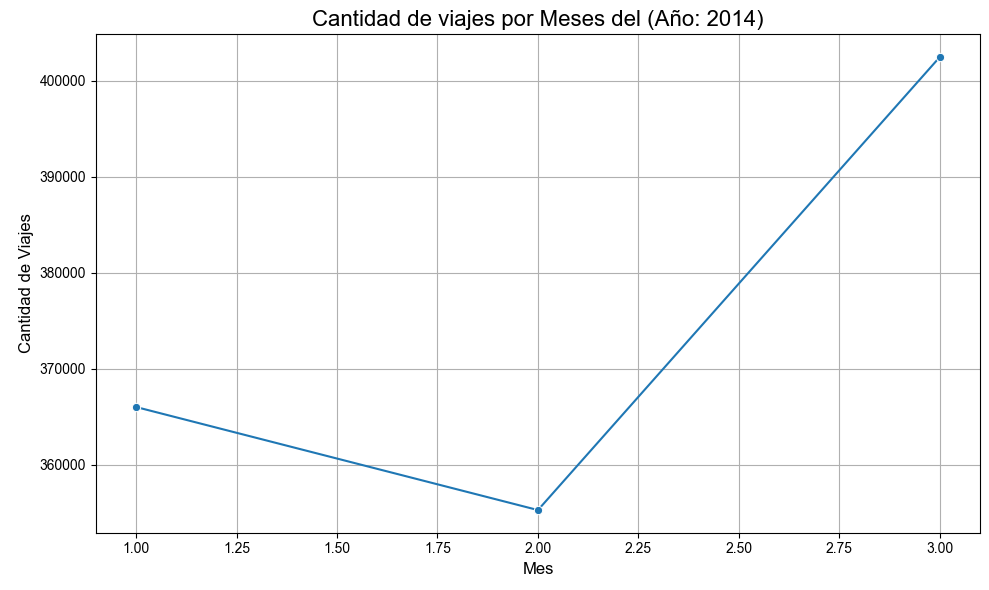

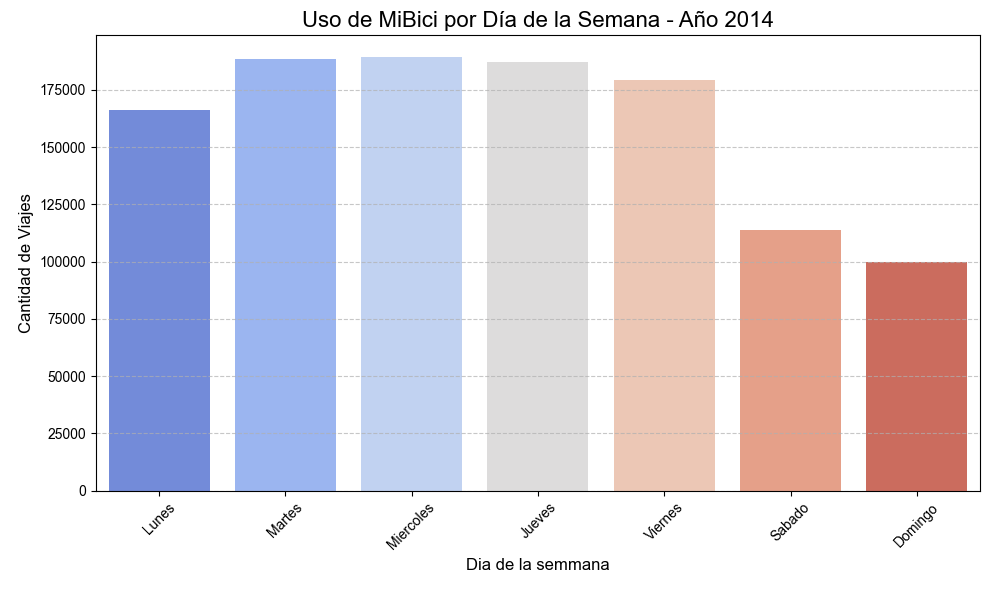

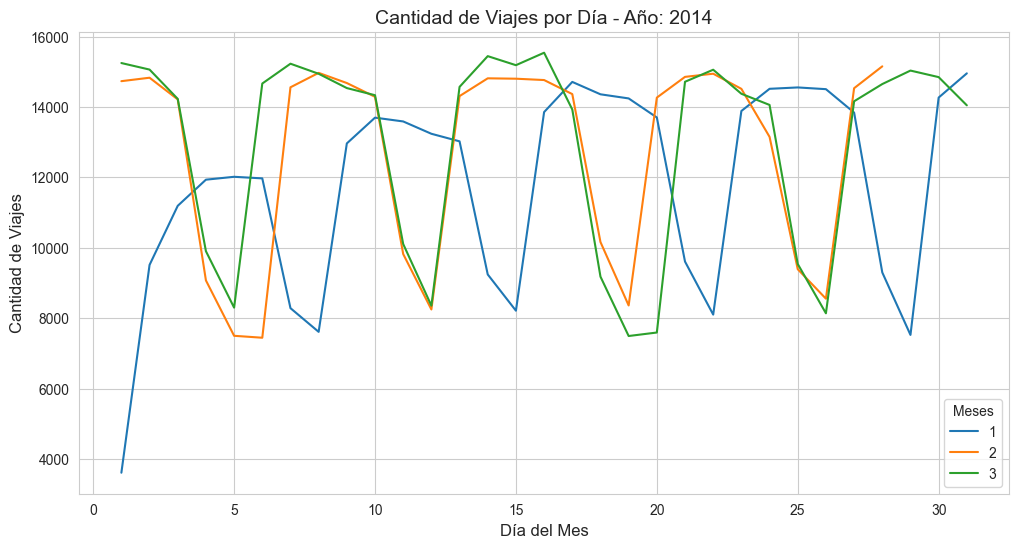

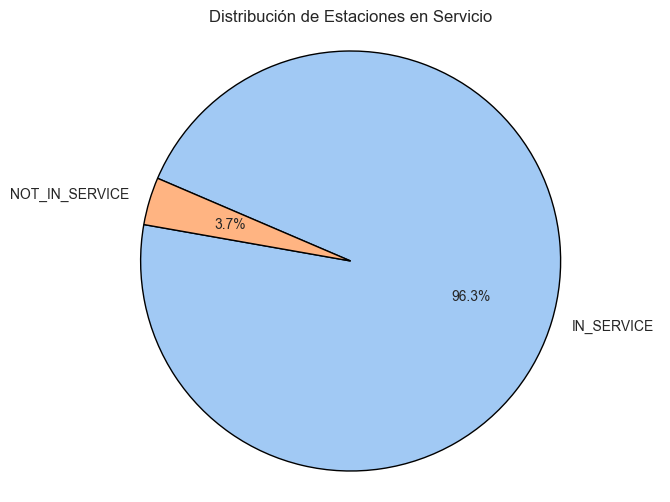

<Figure size 1000x600 with 0 Axes>

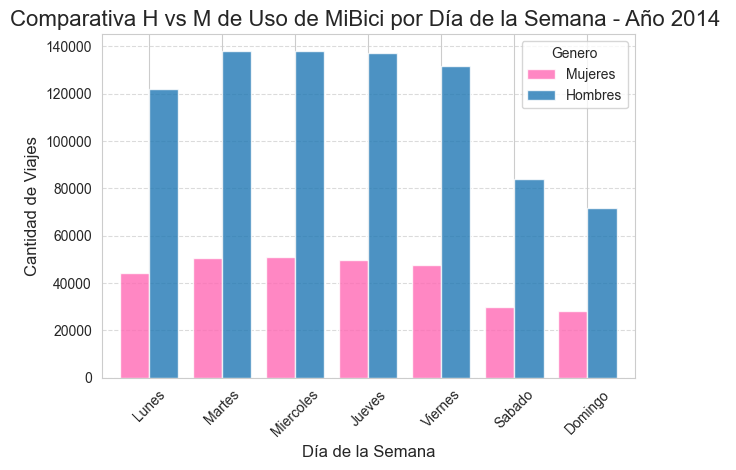

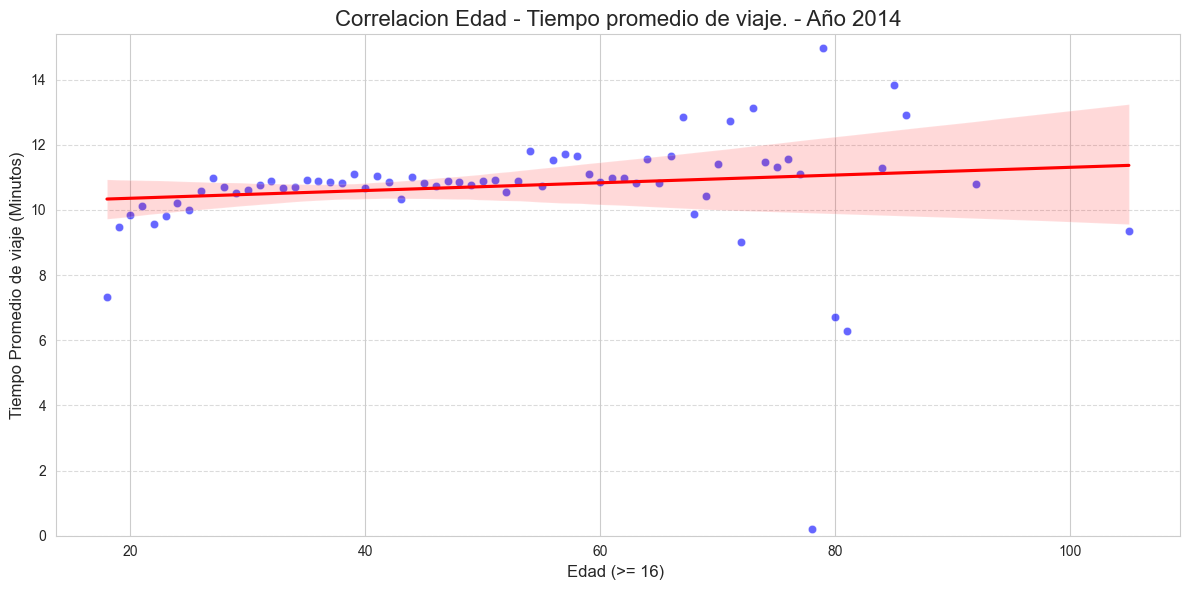

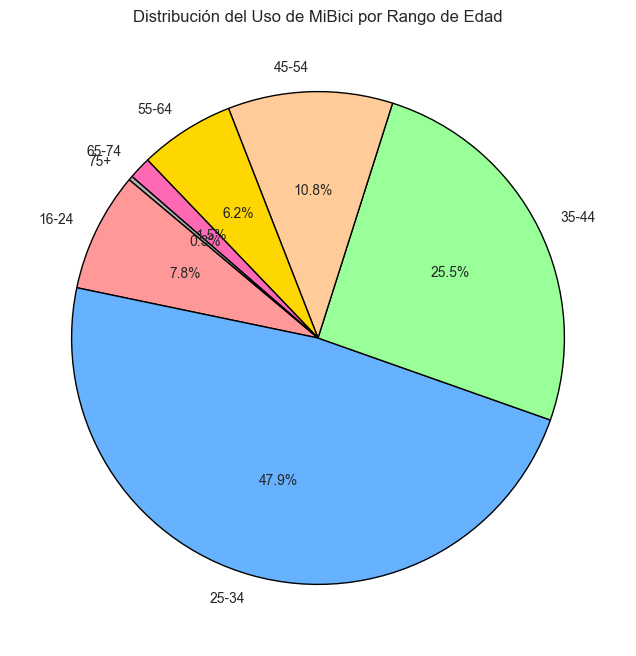

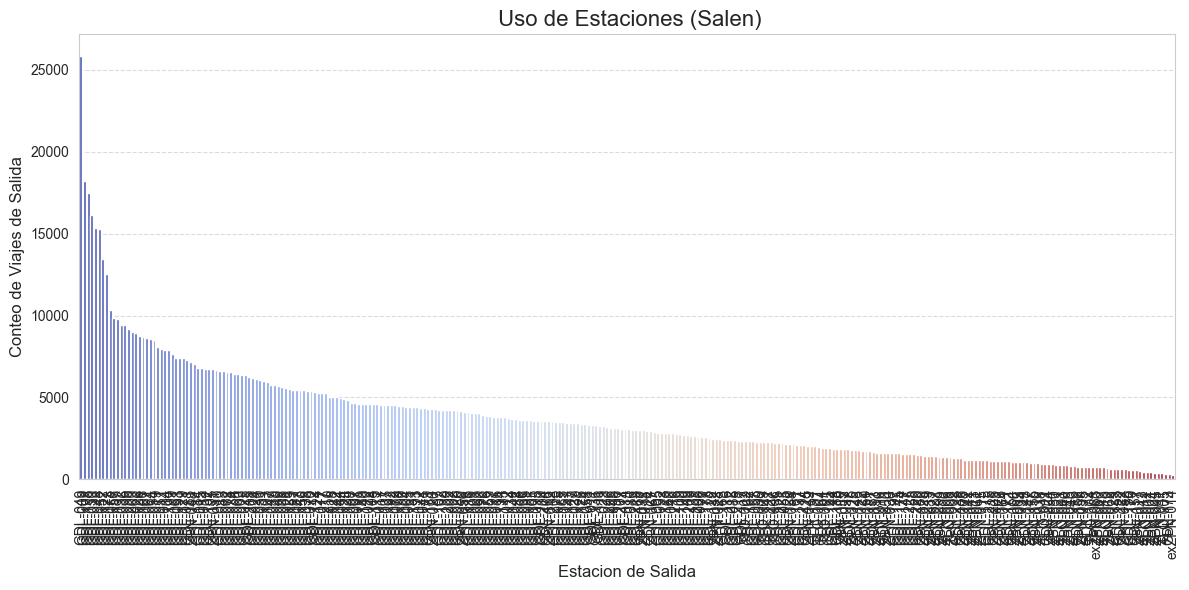

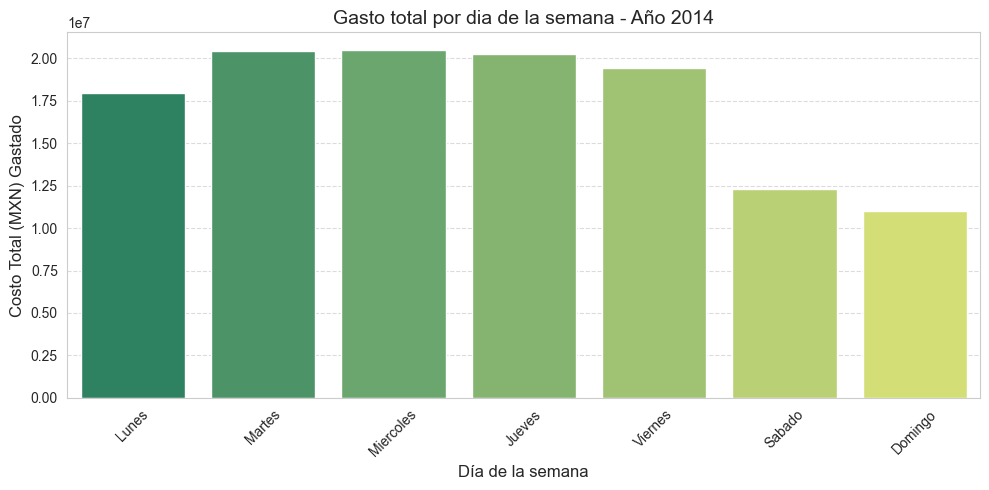

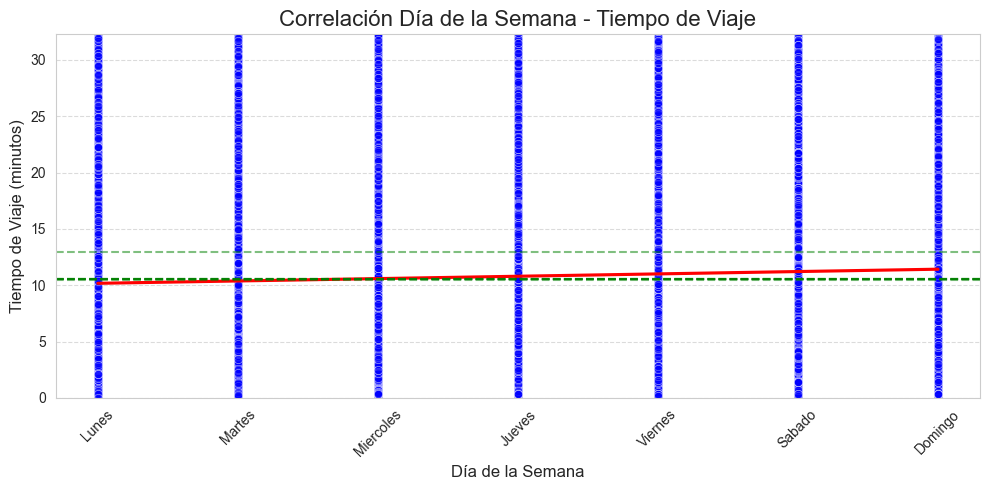

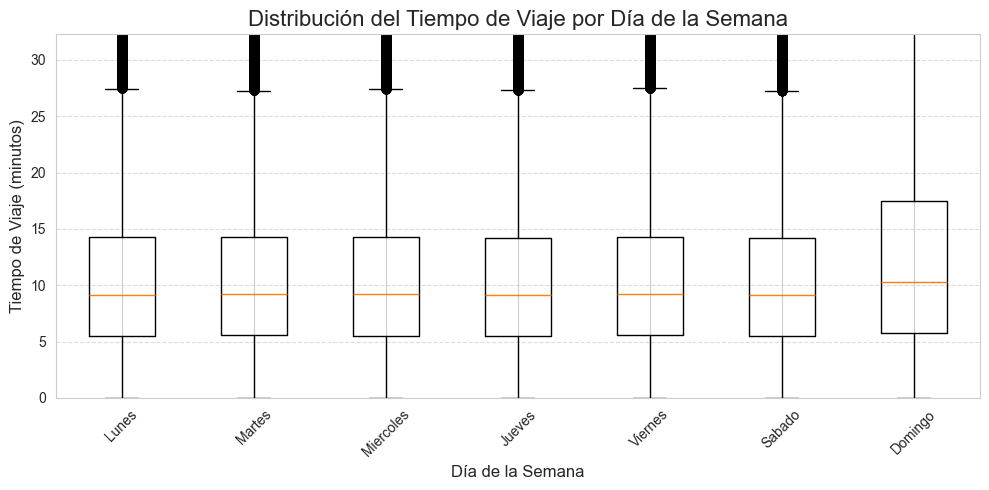

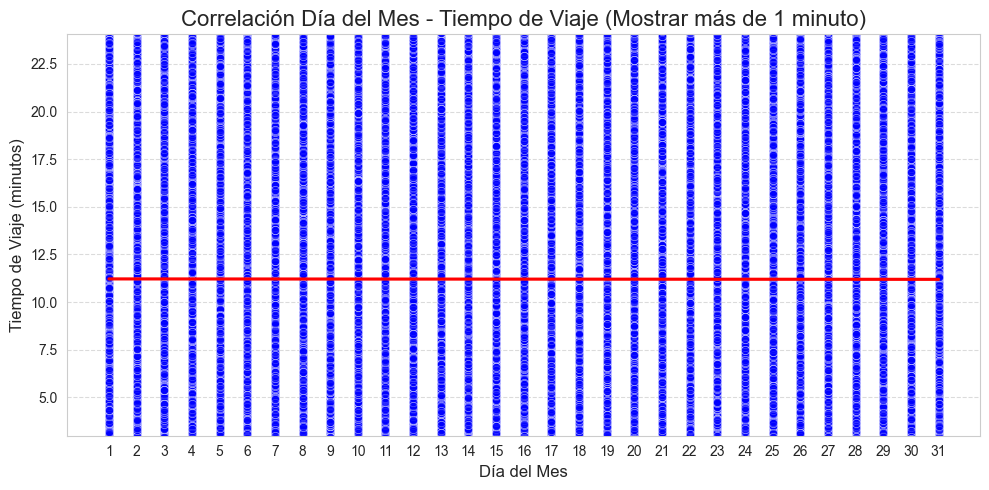

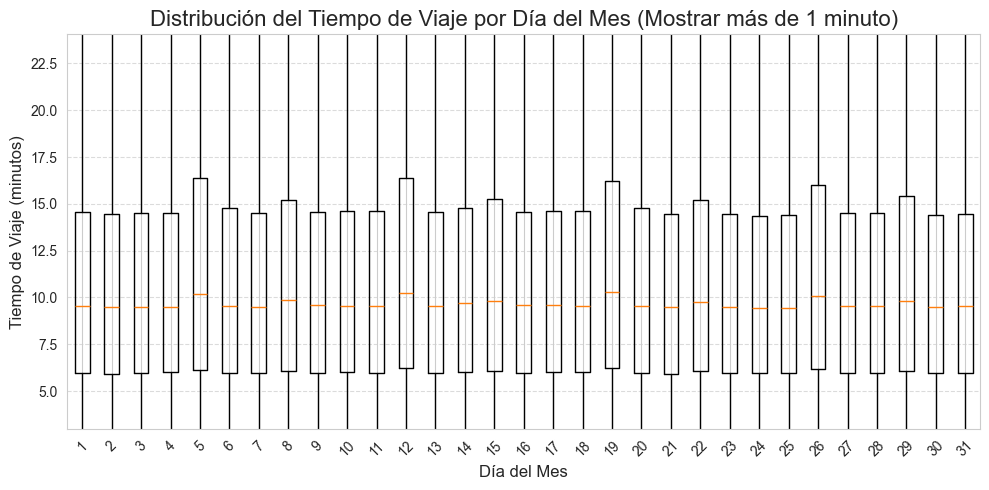

In [43]:
# Mostrar gráficos
if datos_filtrados is not None and not datos_filtrados.empty:
    print("Gráfico de Viajes por Mes y Año:")
    graf_viaje(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de Uso de MiBici durante la semana:")
    graf_uso_semanal(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de Uso de MiBici en días:")
    graf_dias(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de % Estaciones funcionales:")
    graf_estacion_func(nomenclatura_df)

    print("Gráfico de Comparativa Hombres vs Mujeres:")
    graf_gender_versus(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de Correlación Edad - Tiempo Promedio:")
    graf_edad_time(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de Pastel de Edades:")
    graf_edad_pastel(datos_filtrados)

    print("Gráfico de Uso de Estaciones:")
    graf_use_station(datos_filtrados, nomenclatura_df, tipo_conteo)

    print("Gráfico de Gasto Total de MiBici:")
    graf_money(datos_filtrados, opcion_filtrado, year_selected, month_selected)

    print("Gráfico de Correlación Día - Tiempo:")
    graf_dia_time(datos_filtrados)

    print("Gráfico de Correlación Día del Mes - Tiempo de Viaje:")
    graf_dia_mes_time(datos_filtrados)

### Tiempo recorrido y promedios
Calculo de tiempos recorridos y promedio
Este apartado calcula el tiempo recorrido por los usuarios y muestra los promedios de tiempo de viaje.

In [44]:
opcion_time = True
opcion_promedio = True

# Calcular y mostrar tiempo recorrido y promedios
datos_filtrados = tiempo_recorrido(datos_filtrados)
if opcion_time:
    print("Tiempo Recorrido:")
    display(datos_filtrados[['Trip_Id', 'User_Id', 'Gender', 'Age', 'Travel_Time']].head())

if opcion_promedio and datos_filtrados is not None and not datos_filtrados.empty:
    if 'Travel_Time' in datos_filtrados.columns:
        promedio_segundos = datos_filtrados['Travel_Time'].dt.total_seconds().mean()
        horas = int(promedio_segundos // 3600)
        minutos = int((promedio_segundos % 3600) // 60)
        segundos = int(promedio_segundos % 60)
        promedio_formateado = f'{horas:02d}:{minutos:02d}:{segundos:02d}'
        print(f"Promedio del tiempo de viaje para el año {year_selected} y mes {month_selected}: {promedio_formateado}")
    else:
        print('La columna "Travel_Time" no existe en los datos filtrados.')

Tiempo Recorrido:


,Trip_Id,User_Id,Gender,Age,Travel_Time
21919079,26751198,1350606,M,42.0,0 days 00:26:11
21919080,26751199,15163,M,39.0,0 days 00:02:58
21919081,26751200,1534764,M,38.0,0 days 00:10:47
21919082,26751201,1240140,M,29.0,0 days 00:00:55
21919083,26751202,1732214,M,56.0,0 days 00:05:43


Promedio del tiempo de viaje para el año 2014 y mes [12]: 00:10:43
